# "Pins-only" Custom Artifact 01

Data provided by John Slotwinski on 3/25/2016 (filename "3D position check.pdf").


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline 

import os, csv

import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import axes3d, art3d
import pandas as pd

import helpers as gpam


__author__ = "mjp, dgl"
__version__ = "0.0.1"
__status__ = "development"

__copyright__ = "Copyright 2016, JHU/APL"
__license__ = "Apache, Version 2.0"

In [4]:
def plot_pins(Xn, Xm, units='(mm)'):
    plt.figure()
    plt.scatter(Xn[:,0], Xn[:,1], color='magenta')
    plt.scatter(Xm[:,0], Xm[:,1], color='blue')
    plt.legend(['nominal', 'measured'], loc='upper left')
    plt.plot([-52, 52], [0, 0], 'k-')
    plt.plot([0, 0], [-52, 52], 'k-')
    
    plt.xlabel('x location ' + units)
    plt.ylabel('y location ' + units)

    
np.set_printoptions(formatter={'float_kind': lambda x: "%0.4f" % x})

In [5]:
data = pd.read_csv('/Users/pekalmj1/Documents/bb/gpam/data/APL01_M290_Maraging_steel/APL01_pin_features.csv')

Xn = data[['X nominal', 'Y nominal']].as_matrix()
Xm = data[['X measured', 'Y measured']].as_matrix()


# Convert to metric and calculate polar coordinates
mmPerInch = 25.4
Xn *= mmPerInch
Xm *= mmPerInch
D = Xn - Xm
rN, thetaN = gpam.cart2polar(Xn[:,0], Xn[:,1])  # nominal locations in polar coordinates

data.describe()

,X nominal,X measured,Y nominal,Y measured,D nominal,D measured,Z nominal,Z measured
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,-0.010686,-0.011158,0.033444,0.033308,0.173068,0.173868,0.241820,0.242540
std,1.025475,1.024905,0.929964,0.929562,0.045890,0.045894,0.049441,0.049244
min,-1.968500,-1.967700,-1.968500,-1.967600,0.084900,0.085800,0.133500,0.134100
25%,-0.820175,-0.822950,-0.616450,-0.617325,0.153825,0.154300,0.206175,0.206025
50%,-0.001250,-0.000550,-0.001250,-0.000100,0.157500,0.158450,0.270350,0.270100
75%,0.820250,0.822200,0.733100,0.730725,0.201725,0.202525,0.275600,0.277150
max,1.968500,1.966900,1.968500,1.967600,0.272500,0.273600,0.308800,0.309900


## Trial 1: Pin Location Errors

Observe that these pin location errors appear substantially larger than those from the APL artifacts.

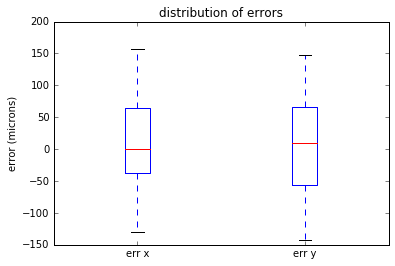

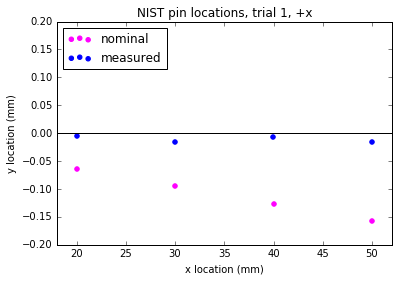

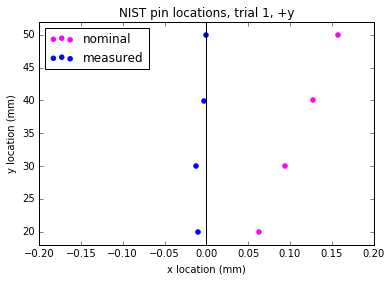

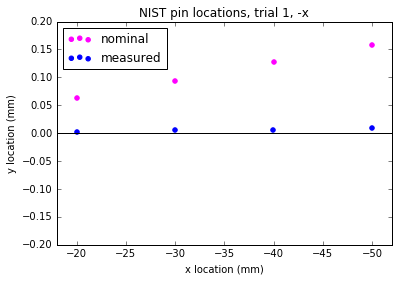

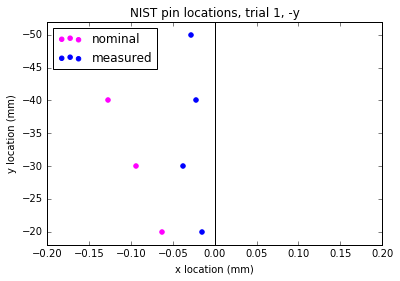

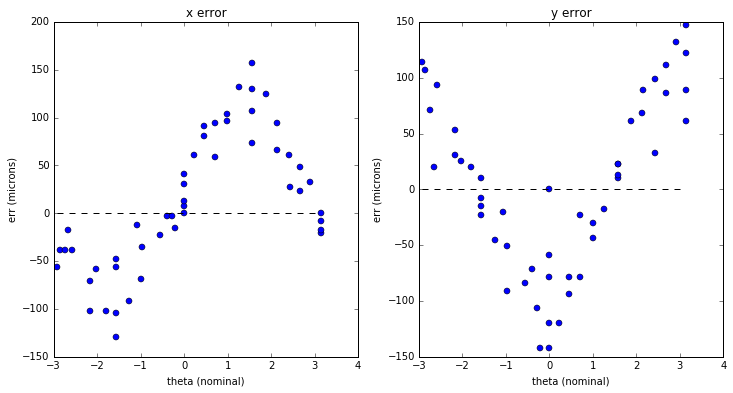

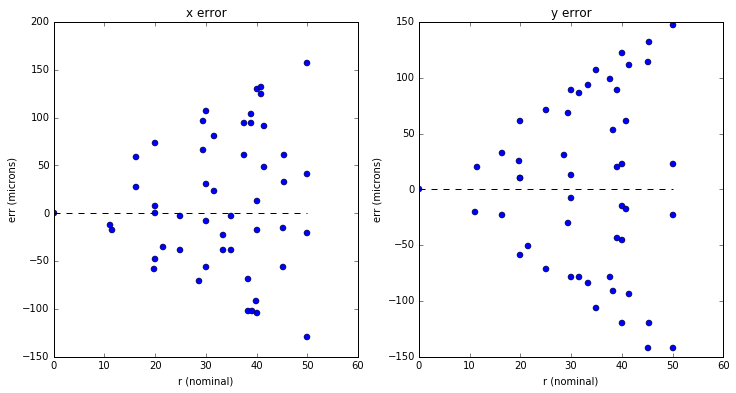

In [6]:

plt.boxplot(1e3*D, labels=["err x", 'err y'])
plt.ylabel('error (microns)')
plt.title('distribution of errors')

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, +x')
plt.xlim([18, 52]);  plt.ylim([-.2, .2])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, +y')
plt.xlim([-.2, .2]);  plt.ylim([18, 52])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, -x')
plt.xlim([-18, -52]);  plt.ylim([-.2, .2])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, -y')
plt.xlim([-.2, .2]);  plt.ylim([-18, -52])

gpam.plot_xy_err_2d(thetaN, 1e3*D[:,0], 1e3*D[:,1], xLabel='theta (nominal)', yLabel='err (microns)')
gpam.plot_xy_err_2d(rN, 1e3*D[:,0], 1e3*D[:,1], xLabel='r (nominal)', yLabel='err (microns)')

## Fit a one-dimensional Gaussian process


Name                              : GP regression
Log-likelihood                    : -65.8651170138
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value      |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |  55.4929439305  |     +ve      |         |         
  Mat52.lengthscale        |  1.70378288769  |     +ve      |         |         
  Gaussian_noise.variance  |  5.15069178123  |     +ve      |         |         

Name                              : GP regression
Log-likelihood                    : -72.1939692723
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value      |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |   71.188988974  |     +ve      |         |         
  Mat52.lengthscale        |  2.08920149179  |     +

 /Users/pekalmj1/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


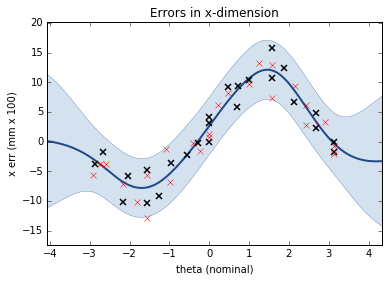

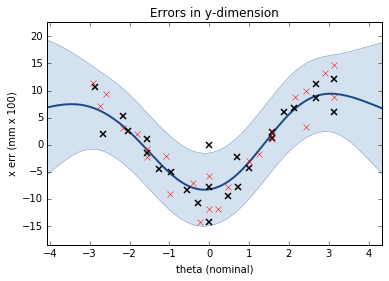

In [7]:
import GPy

# For visualization purposes, show GP fit to all measured data.
# We'll do some loo analysis later on.

def to_col(v): 
    return np.reshape(v, (v.size,1))

# Choose scale factor sf so that x and y are of similar magnitude
sf = 1e2
units = 'mm x %g' % sf
trainIdx = np.arange(0, thetaN.size, step=2)
testIdx = np.arange(1, thetaN.size, step=2)

_x = thetaN
dx = sf * D[:,0]
dy = sf * D[:,1]

kernel = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dx[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dx[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in x-dimension')


model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dy[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dy[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in y-dimension')


Name                              : GP regression
Log-likelihood                    : -141.008703361
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |   2895.59751295  |     +ve      |         |         
  Mat52.lengthscale        |  0.252989935948  |     +ve      |         |         
  Gaussian_noise.variance  |   2308.14883322  |     +ve      |         |         

Name                              : GP regression
Log-likelihood                    : -142.445970199
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |        Value        |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |  1.23195228302e-15  |     +ve      |         |         
  Mat52.lengthscale        |  1.23195228

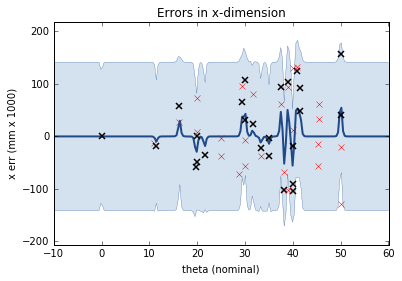

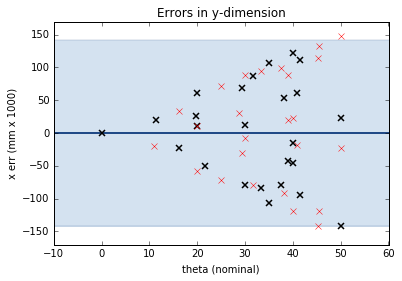

In [8]:
# also look as a function of r

# Choose scale factor sf so that x and y are of similar magnitude
sf = 1e3
units = 'mm x %g' % sf
trainIdx = np.arange(0, rN.size, step=2)
testIdx = np.arange(1, rN.size, step=2)

_x = rN
dx = sf * D[:,0]
dy = sf * D[:,1]

kernel = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dx[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dx[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in x-dimension')


model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dy[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dy[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in y-dimension')

## 2D example

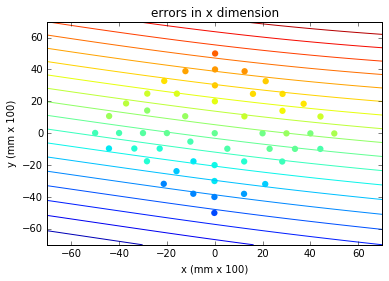

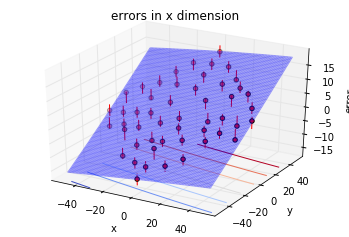

In [9]:
# We'll do some loo analysis later on.

# Choose scale factor sf so that x and y are of similar magnitude
sf = 1e2
units = 'mm x %g' % sf
dx = sf * D[:,0]

kernel = GPy.kern.Matern52(2, ARD=False, lengthscale=10.)
model = GPy.models.GPRegression(Xn, to_col(dx), kernel)
model.optimize(messages=True, max_f_eval=1000)
#print model
model.plot()
plt.title('errors in x dimension')
plt.xlabel('x (%s)' % units)
plt.ylabel('y (%s)' % units)


gpam.plot_gp_mean_2d(model, Xn, to_col(dx))
plt.title('errors in x dimension')